In [1]:
import pandas as pd
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, SGDRegressor, Lars, BayesianRidge
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 

from scipy import stats
from scipy.stats import norm, skew, boxcox
from scipy.special import boxcox1p, inv_boxcox
def metric(y_true, y_pred):
    return np.mean(np.sum(np.abs(y_true - y_pred), axis=0)/np.sum(y_true, axis=0))

In [2]:
fnc = pd.read_csv('fnc.csv')
loading = pd.read_csv('loading.csv')
reveal = pd.read_csv('reveal_ID_site2.csv')
sample = pd.read_csv('sample_submission.csv')
train_scores = pd.read_csv('train_scores.csv')

fnc_features, loading_features = list(fnc.columns[1:]), list(loading.columns[1:])
loading = loading.drop(['IC_20'], axis=1)
loading_features.remove('IC_20')

In [20]:
df = fnc.merge(loading, on="Id")

In [21]:
SEED = 0
NUM_FOLDS = 7
FNC_SCALE = 1/500

In [22]:
scaler = MinMaxScaler()
df.iloc[:,1:] = scaler.fit_transform(df.iloc[:,1:])
scaler = RobustScaler()
df.iloc[:,1:] = scaler.fit_transform(df.iloc[:,1:])

train_scores["is_train"] = True
df = df.merge(train_scores, on="Id", how="left")

test_df = df[df["is_train"] != True].copy()
df = df[df["is_train"] == True].copy()

In [23]:
df[fnc_features] *= FNC_SCALE
test_df[fnc_features] *= FNC_SCALE

In [112]:
imp_features = ['IC_22','IC_12','IC_15','IC_04','IC_10','IC_08','IC_21','IC_02']
poly_features = []
for col in imp_features:
    df['poly_{}'.format(col)] = np.exp(df[col].max() - df[col])
    test_df['poly_{}'.format(col)] = np.exp(test_df[col] - test_df[col])
    poly_features.append('poly_{}'.format(col))
     

scaler = MinMaxScaler()
df.loc[:,poly_features] = scaler.fit_transform(df.loc[:,poly_features])
test_df.loc[:,poly_features] = scaler.fit_transform(test_df.loc[:,poly_features])
scaler = RobustScaler()
df.loc[:,poly_features] = scaler.fit_transform(df.loc[:,poly_features])
test_df.loc[:,poly_features] = scaler.fit_transform(test_df.loc[:,poly_features])

In [9]:
df

Id  SCN(53)_vs_SCN(69)  SCN(98)_vs_SCN(69)  SCN(99)_vs_SCN(69)  \
0      10001            0.000737            0.000334            0.000876   
1      10002            0.000303           -0.000050            0.000435   
3      10004            0.000266            0.000517            0.000982   
4      10005            0.000584            0.000503            0.000833   
6      10007            0.000047            0.000504            0.001143   
...      ...                 ...                 ...                 ...   
11745  21746            0.000079            0.000156            0.000832   
11746  21747            0.000484            0.000417            0.001205   
11749  21750            0.000456           -0.000445            0.000501   
11751  21752            0.000237            0.000904            0.001217   
11753  21754            0.001089            0.000540            0.001006   

       SCN(45)_vs_SCN(69)  ADN(21)_vs_SCN(69)  ADN(56)_vs_SCN(69)  \
0                0.000682           -0.000373            0.000098   
1                0.000836           -0.000454           -0.000128   
3                0.000685            0.000182            0.000216   
4                0.001023           -0.000725           -0.000329   
6                0.000677           -0.000209           -0.000399   
...                   ...                 ...                 ...   
11745            0.000874           -0.000235            0.000256   
11746            0.001266           -0.000267           -0.000428   
11749            0.000885           -0.000442           -0.000470   
11751            0.000845           -0.000213           -0.000017   
11753            0.001303           -0.000506            0.000201   

       SMN(3)_vs_SCN(69)  SMN(9)_vs_SCN(69)  SMN(2)_vs_SCN(69)  ...  \
0               0.000243          -0.000349          -0.000463  ...   
1              -0.000288          -0.000236          -0.000110  ...   
3               0.000058          -0.000052           0.000189  ...   
4              -0.000578          -0.000031          -0.000175  ...   
6              -0.000482          -0.000382          -0.000057  ...   
...                  ...                ...                ...  ...   
11745           0.000124          -0.000409          -0.000201  ...   
11746          -0.000785          -0.000450          -0.000775  ...   
11749          -0.000593          -0.000546          -0.000213  ...   
11751          -0.000020          -0.000244           0.000186  ...   
11753          -0.000259           0.000208          -0.000047  ...   

       domain1_var1  domain1_var2  domain2_var1  domain2_var2  is_train  \
0         30.571975     62.553736     53.325130     51.427998      True   
1         50.969456     67.470628     60.651856     58.311361      True   
3         53.152498     58.012103     52.418389     62.536641      True   
4               NaN           NaN     52.108977     69.993075      True   
6         49.197021     65.674285     40.151376     34.096421      True   
...             ...           ...           ...           ...       ...   
11745     21.358872     61.165998     51.778483     54.640179      True   
11746     68.169675     29.907995     55.349257     54.019517      True   
11749     55.114811     60.878271     38.617246     50.679885      True   
11751     59.844808     72.303110     55.458281     46.870235      True   
11753     56.594193     34.605868     49.922535     50.383078      True   

        pred_age  pred_domain1_var1  pred_domain1_var2  pred_domain2_var1  \
0      60.217588          53.687788          58.999813          48.643065   
1      55.804389          52.683472          59.121673          48.143189   
3      52.090534          53.526919          58.915798          47.281727   
4      61.277695          55.526163          59.146186          48.786143   
6      41.731387          49.978989          59.319577          46.135278   
...          ...                ...                .

In [24]:
target = 'age'
features = loading_features + fnc_features 
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, df[df[target].notnull()][features], df[df[target].notnull()][target], scoring='neg_mean_squared_error', cv=NUM_FOLDS))
    return rmse

In [25]:
%%time

alphas_ridge = [ 0.0035, 0.004, 0.0045 ]
cv_ridge = [rmse_cv(Ridge(alpha = al)).mean() for al in alphas_ridge]

cv_ridge = pd.Series(cv_ridge, index=alphas_ridge)
print(cv_ridge)

0.0030    9.057407
0.0035    9.053907
0.0040    9.052768
0.0045    9.053203
0.0050    9.054718
dtype: float64
CPU times: user 42.9 s, sys: 10.8 s, total: 53.7 s
Wall time: 14.7 s


Text(0, 0.5, 'rmse')

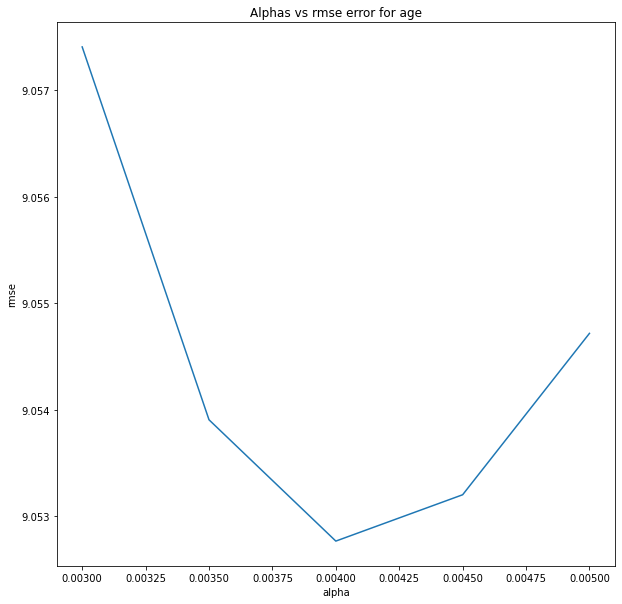

In [26]:
plt.figure(figsize=(10,10))
cv_ridge.plot(title='Alphas vs rmse error for {}'.format(target))
plt.xlabel('alpha')
plt.ylabel('rmse')

In [8]:
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)
features = loading_features + fnc_features
overal_score = 0
for target, c, w, al in [ ('age', 6, 0.3, 0.004), ('domain1_var1', 0, 0.175, 0.08),('domain1_var2', 0, 0.175, 0.22),('domain2_var1', 0, 0.175, 0.05),('domain2_var2', 0, 0.175, 0.047)]:    

    y_oof = np.zeros(df.shape[0])
    y_test = np.zeros((test_df.shape[0], NUM_FOLDS))
    
    for f, (train_ind, val_ind) in enumerate(kf.split(df, df)):
        train_df, val_df = df.iloc[train_ind], df.iloc[val_ind]
        train_df = train_df[train_df[target].notnull()]

        model = Ridge(alpha = al)
        model.fit(train_df[features], train_df[target])

        y_oof[val_ind] = model.predict(val_df[features])
        y_test[:, f] = model.predict(test_df[features])
        
    df["pred_{}".format(target)] = y_oof
    test_df[target] = y_test.mean(axis=1)
    
    score = metric(df[df[target].notnull()][target].values, df[df[target].notnull()]["pred_{}".format(target)].values)
    overal_score += w*score
    print(target, np.round(score, 5), np.round(score, 4))
    
print("\nOverall score:", np.round(overal_score, 5), np.round(overal_score, 4))

age 0.14716 0.1472
domain1_var1 0.15206 0.1521
domain1_var2 0.15119 0.1512
domain2_var1 0.18276 0.1828
domain2_var2 0.17702 0.177

Overall score: 0.16018 0.1602


In [44]:
sub_df = pd.melt(test_df[["Id", "meta_age", "meta_domain1_var1", "meta_domain1_var2", "meta_domain2_var1", "meta_domain2_var2"]], id_vars=["Id"], value_name="Predicted")
sub_df.variable = sub_df.variable.apply(lambda x: x.replace('meta_',''))
sub_df["Id"] = sub_df["Id"].astype("str") + "_" +  sub_df["variable"].astype("str")

sub_df = sub_df.drop("variable", axis=1).sort_values("Id")
assert sub_df.shape[0] == test_df.shape[0]*5
sub_df.head(10)

Id  Predicted
0               10003_age  58.718015
5877   10003_domain1_var1  49.159053
11754  10003_domain1_var2  60.187182
17631  10003_domain2_var1  50.157359
23508  10003_domain2_var2  55.064548
1               10006_age  62.683079
5878   10006_domain1_var1  55.373461
11755  10006_domain1_var2  57.445360
17632  10006_domain2_var1  50.060041
23509  10006_domain2_var2  51.442273

In [46]:
sub_df.to_csv('subs/checking_effect_of_meta_with_targetself.csv', index=False)